# hw 5: kernel density estimation (KDE)

In [1]:
using CSV
using DataFrames
using PyPlot
using Statistics
using Random
using LaTeXStrings # for L"$x$" to work instead of needing to do "\$x\$"
using Printf

# (optional)change settings for all plots at once, e.g. font size
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16

# use PyCall to call in Seaborn
using PyCall
sns = pyimport("seaborn");

# note: some have done the following to bring `kdeplot` and `rugplot` into 
# the namespace but I recommend the above. you need to install Seaborn, the 
# Python package.
# using Seaborn

## data on forest fires in the northeast region of Portugal

(1) read in `forestfires.csv` as a `DataFrame`. [source](https://archive.ics.uci.edu/ml/datasets/Forest+Fires)

* each row corresponds to the occurance of a forest fire. 
* the `:temp` attribute is the temperature in Celsius degrees when the forest fire occurred
* the `:RH` attribute is the relative humidity in % when the forest fire occurred

In [2]:
df_fires = CSV.read(joinpath("Data", "forestfires.csv"), copycols=true)
first(df_fires, 6)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH
,Int64,Int64,String,String,Float64,Float64,Float64,Float64,Float64,Int64
1,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51
2,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33
3,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33
4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97
5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99
6,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29


## using Seaborn to do KDE

(2) use Seaborn's [kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) function and [rugplot](https://seaborn.pydata.org/generated/seaborn.rugplot.html) function to, on the same plot, draw a rugplot and 1D KDE of the temperature during forest fires in Portugal.

* shade in the area under the curve (see `shade` in the documentation)
* use the cosine kernel, denoted as `"cos"` in Seaborn (see `kernel` in the documentation) the cosine kernel has finite, compact support, unlike the Gaussian kernel
* label the x, y-axes with appropriate units (note: both have units!)

note regarding translation of Seaborn (Python) documentation to Julia: keep in mind that we need to pass strings `kernel="gau"` in Julia as opposed to `kernel='gau'` which works in Python.

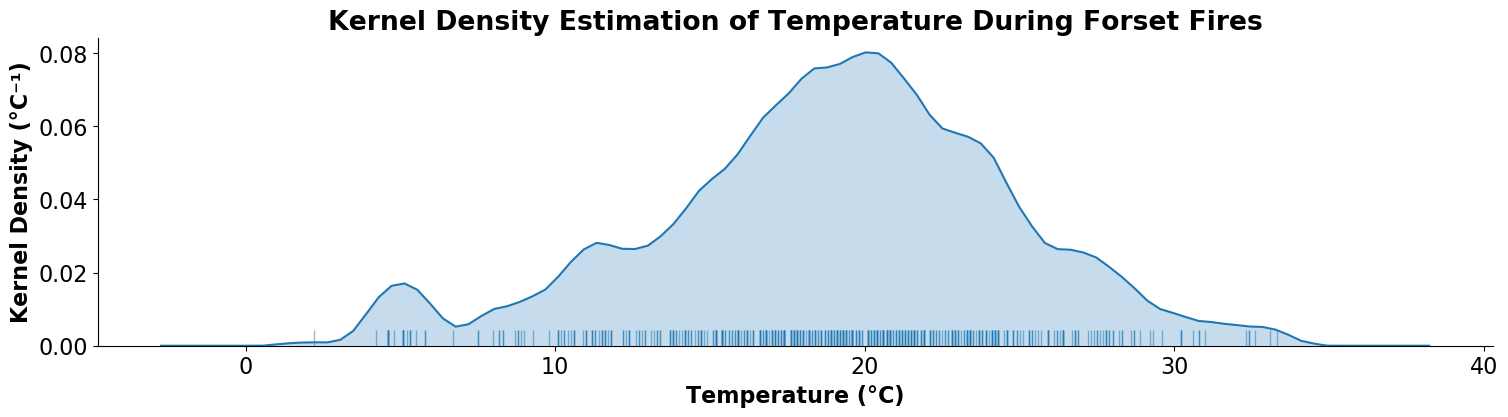

In [3]:
fig, ax = subplots(1, 1, figsize=(18, 4))
sns.kdeplot(df_fires[!, :temp], kernel="cos", shade=true, ax=ax)
sns.rugplot(df_fires[!, :temp], ax=ax, alpha=0.5)
ax.set_xlabel("Temperature (°C)", weight="bold")
ax.set_ylabel("Kernel Density (°C⁻¹)", weight="bold")
ax.set_title(
    "Kernel Density Estimation of Temperature During Forset Fires", 
    weight="bold"
)
sns.despine()

(3) draw a scatter plot to visualize the relationship, during forest fires, between:
* x-axis: temperature
* y-axis: relative humidity

label the x- and y-axes along with units.

use green "+" markers.

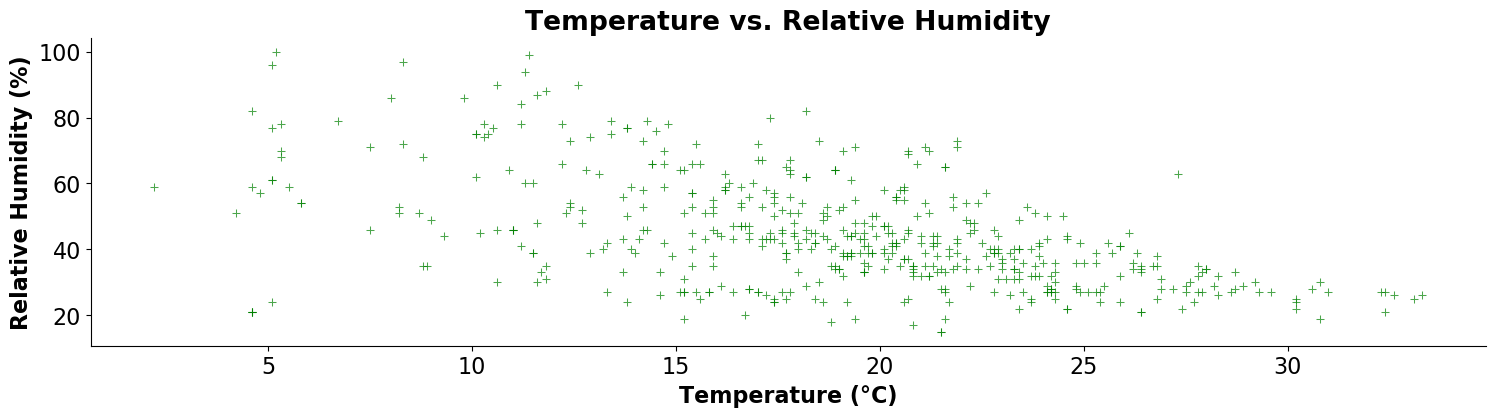

In [4]:
fig, ax = subplots(1, 1, figsize=(18, 4))
sns.scatterplot(
    df_fires[!, :temp], 
    df_fires[!, :RH], 
    ax=ax,
    color="g",
    marker="+", 
    alpha=0.7
)
ax.set_xlabel("Temperature (°C)", weight="bold")
ax.set_ylabel("Relative Humidity (%)", weight="bold")
ax.set_title("Temperature vs. Relative Humidity", weight="bold")
sns.despine()

(4) now draw a bivariate KDE using Seaborn's [kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) function that corresponds to your scatter plot in (3).
* devote the x-axis to temperature
* devote the y-axis to relative humidity
* label the x, y- axes with units
* pass `shade=true` to shade between the contours
* pass `shade_lowest=false` to avoid shading regions of temperature-relative humidity space where forest fires were very unlikely to occur.
* pass `cmap="Greens"` to change the colormap to use green colors for the shading.

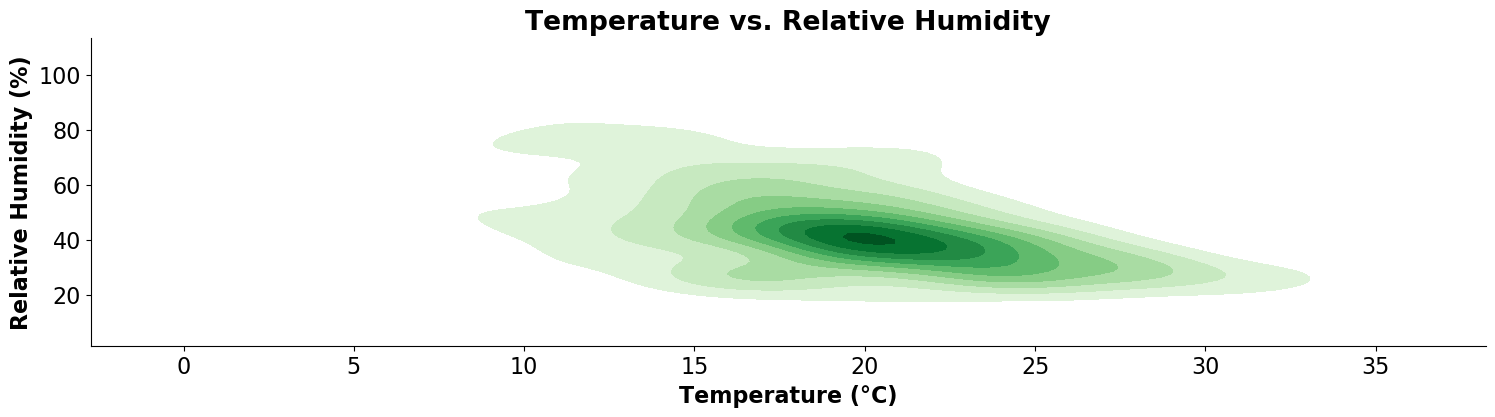

In [5]:
fig, ax = subplots(1, 1, figsize=(18, 4))
sns.kdeplot(
    df_fires[!, :temp],
    df_fires[!, :RH], 
    ax=ax, 
    shade=true, 
    shade_lowest=false,
    cmap="Greens"
)
ax.set_xlabel("Temperature (°C)", weight="bold")
ax.set_ylabel("Relative Humidity (%)", weight="bold")
ax.set_title("Temperature vs. Relative Humidity", weight="bold")
sns.despine()

## coding up your own 1D top hat KDE
To intimately understand KDE, let's code up own own KDE with a new kernel we haven't seen before, the top hat function, which looks like a top hat. See what the top hat kernel looks like [here](https://scikit-learn.org/stable/_images/sphx_glr_plot_kde_1d_002.png). The top hat function has finite and compact [support](https://en.wikipedia.org/wiki/Support_(mathematics)) and is (piecewise) flat. The top hat kernel is implemented in scikitlearn's kernel density estimate module if you are interesting in checking your code. let $X$ denote the random variable whose density we seek to estimate (via top hat kernel density estimation).

(5) write a function `K_top_hat(x::Float64, x_i::Float64, λ::Float64)` the returns the value of the top hat kernel density at `x` conributed by data point `x_i`. `λ` is the bandwidth of the top hat kernel, which is half of its width. think carefully about what the height should be...

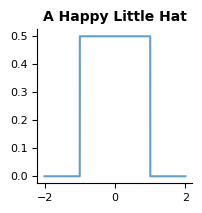

In [6]:
"""
Top hat kernel

Parameters
----------
x : Float64
    Point at which to evaluate kernel density
xᵢ : Float64
    iᵗʰ data point
λ : Float64
    Bandwith

Returns
-------
Float64
    Kernel evaluation about x from xᵢ
"""
function K_top_hat(x::Float64, xᵢ::Float64, λ::Float64)
    # This should probably sum to 1 to be a proper kernel
    # ∫dx from x-λ to x+λ = 1
    # height should be 1/(2λ) to make this happen
    return (abs(x-xᵢ) > λ) ? 0 : 1 / (2 * λ)
end

@assert K_top_hat(0., 1., 1.) ≈ 1 / 2
@assert K_top_hat(0., 5., 1.) ≈ 0
x = range(-2, stop=2, length=1000000)
@assert (sum([K_top_hat(0., xᵢ, 1.) for xᵢ in x]) * diff(x)[1] - 1) < 1e-5
fig, ax = subplots(1, 1, figsize=(2, 2))
ax.plot(x, [K_top_hat(0., xᵢ, 1.) for xᵢ in x], alpha=0.7)
ax.set_title("A Happy Little Hat", weight="bold", size=10)
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)
sns.despine()

(6) write a function `top_hat_kde(x::Float64, x_sample::Array{Float64}, λ::Float64)` that takes in the point `x` at which we seek to estimate the density, the array of samples of $x$ (the data and the `x_i`'s for `K_top_hat`) `x_sample`, and the bandwidth `λ` of the top hat kernel used to make the density estimate, then returns the top hat kernel density estimate at `x`.

In [7]:
"""
Top hat kde

Parameters
----------
x : Float64
    Point at which to estimate kernel density
xₛₐₘₚₗₑ : Array{Float64}
    Array of data points
λ : Float64
    Bandwith

Returns
-------
Float64
    KDE at x
"""
function top_hat_kde(x::Float64, xₛₐₘₚₗₑ::Array{Float64}, λ::Float64)
    return sum([K_top_hat(x, xᵢ, λ) for xᵢ in xₛₐₘₚₗₑ]) / length(xₛₐₘₚₗₑ)
end

top_hat_kde

(7) finally, use your function `top_hat_kde` to estimate the density of temperatures during forest fires in Portugal at a dense span of temperatures ranging from 0 to 50.0. Use a bandwidth of 1.5. plot the density as in question (2) and compare. What strikes you as a qualitative difference between the KDE using top hat vs. cosine kernel in (2)?

note: in comparing the scale on the y-axis here and in your plot from question (2) generated with Seaborn, you should get a hint of whether or not you chose the height of the top hat kernel correctly. Remember that the total kernel density should integrate to 1.0.

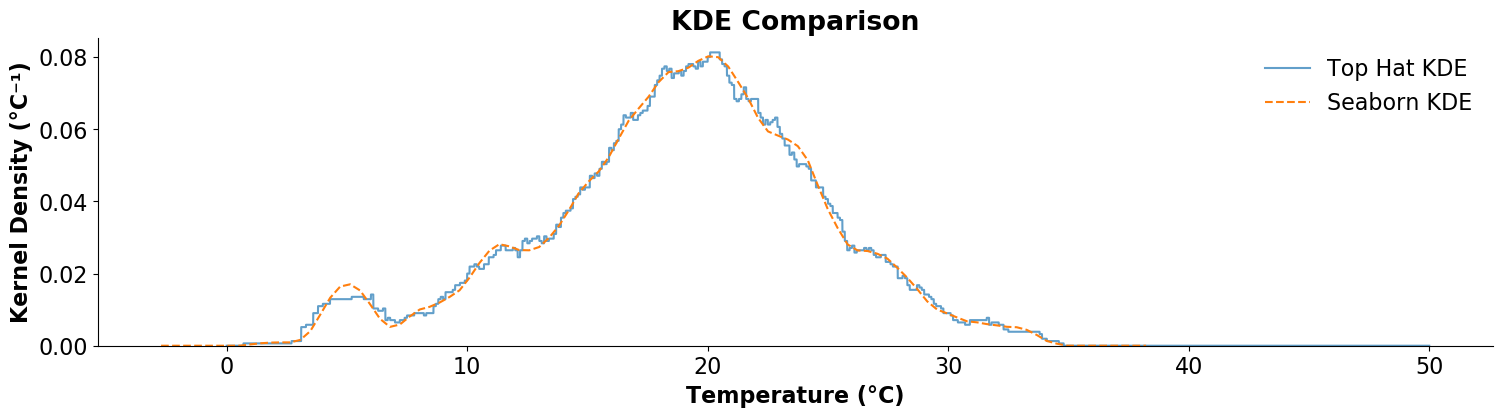

In [8]:
x = range(0, stop=50, length=10000)
kde_x = [top_hat_kde(xᵢ, df_fires[!, :temp], 1.5) for xᵢ in x]
fig, ax = subplots(1, 1, figsize=(18, 4))
ax.plot(x, kde_x, alpha=0.7, label="Top Hat KDE")
sns.kdeplot(
    df_fires[!, :temp],
    ax=ax, 
    kernel="cos",
    ls="--", 
    alpha=1,
    label="Seaborn KDE"
)
ax.legend(frameon=false)
ax.set_xlabel("Temperature (°C)", weight="bold")
ax.set_ylabel("Kernel Density (°C⁻¹)", weight="bold")
ax.set_title("KDE Comparison", weight="bold")
sns.despine()

# 1e-3 is close enough right? riiight?
@assert abs(sum(kde_x) * diff(x)[1] - 1) < 1e-3

The top hat KDE looks relatively similar to the cosine KDE from (2), as shown above. The biggest qualitative difference between the two is that the top hat looks more jagged. This is unsurprising, since the top hat function has a binary output of $x \in \{0, (2\lambda)^{-1}\}$ which gives no opportunity for smoothing.